Analysis script to analyze pose tracking data from DeepLabCut. Takes 2D coordinates from each camera and converts them to 3D. Outputs various analyses and plots of limb positions in 3D space. 

Structure is such that the cell "Main Script" runs the primary function RunAll which calls the other processing functions. 

SET PATHS AND IMPORT MODULES

In [30]:
#Customize this paths dictionary for your local paths. 
pathsDict = {
    'coordPath': 'D:\data\Behavior data\dlc_data_201020\coords and dlc\model_1_coordinates.csv', 
    'DLCPath': 'D:\data\Behavior data\dlc_data_201020\coords and dlc',
    'PlotPath' : 'D:\data\Behavior data\dlc_data_201020\Plotting files'
}


In [34]:
import os
from functools import reduce    # used to get common bodyparts amoung different cameras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

FUNCTIONS

In [8]:
# BUILD MODEL - uses 2D coordinates (probably obtained by a calibration experiment) to estimate coordinates in 3D
# input: path to coordinate csv file, list of model IDs as strings ['fl'/'fr'/'bot'] (optional: long = 1 to show results and MSE for SVM model)
# output: trained SVM regressor that converts model cameras (2D) to X/Y/Z

def Build_Model(coordinatePath, model, long = 0):

    All_Data = pd.read_csv(coordinatePath)

    mod_col = []
    for m in model:
        mod_col.append(m.upper()+'_x')
        mod_col.append(m.upper()+'_y')
    mod_col += ['X','Y','Z']
    All_Data = All_Data[mod_col]
    
    X_train_full, X_test, y_train_full, y_test = train_test_split( 
            All_Data.iloc[:,:-3], All_Data.iloc[:,-3:], random_state=42,  test_size = 0.25)
    
    svm = SVR(kernel="poly", degree=2, C=1500, epsilon=0.01, gamma="scale")
    regr = MultiOutputRegressor(svm)
    regr.fit(X_train_full, y_train_full)

    if long:
        test_predictions = regr.predict(X_test)
        test_MSE = mean_squared_error(test_predictions, y_test)
        print('Test MSE: ' + str(test_MSE))
        
        X = All_Data.iloc[:,:-3]
        Y = All_Data.iloc[:,-3:]
        
        CV_predictions = cross_val_predict(regr, X, Y, cv=10)
        MSE = mean_squared_error(CV_predictions, Y)
        print('CV MSE: ' + str(MSE))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(CV_predictions[:,0], CV_predictions[:,1], CV_predictions[:,2], color = 'blue', label = 'pred')
        ax.scatter(All_Data.iloc[:,-3], All_Data.iloc[:,-2], All_Data.iloc[:,-1], color = 'red', label = 'real')
        plt.legend()

    return regr

In [9]:
# PREPROCESS DLC
# input: DLC csv as df
# output: processed DLC file with likelihood values and extra info removed

def PreProcess_DLC_data(df):

    for y in range (df.shape[1]):        
        df.rename(columns={df.columns[y]:df.iloc[0,y]+'_'+df.iloc[1,y]}, inplace=True)
        
    df_proc = df.iloc[2:,1:]
    
    li_columns = [col for col in df_proc.columns if 'likelihood' in col]
    df_proc = df_proc.drop(columns=li_columns)

    df_proc = df_proc.astype(float).reset_index(drop=1)
        
    return df_proc

In [10]:
# STANDARDIZE COLUMNS
# input: list of preprocessed DLC dfs
# output: list of standardized DLC dfs (only includes common bodyparts/columns), list of bodyparts/columns

def Standardize_columns(dfs):
   
    col = []
    for df in dfs:
        col.append(df.columns.tolist())

    same_col = reduce(np.intersect1d, col)
    if len(same_col) == 0:
        print('no matching body parts amongst all cameras!')
        return None, None
    
    columns = []
    for col in same_col[::2]:
        columns.append(col[:-2]+'_X')
        columns.append(col[:-2]+'_Y')
        columns.append(col[:-2]+'_Z')

    dfs_stand = []
    for df in dfs:
        dfs_stand.append(df[same_col])

    return dfs_stand, columns

In [11]:
# PREDICT X/Y/Z
# input: list of standardized dfs, number of bodyparts, number of cameras, trained regressor
# output: numpy array of predicted X/Y/Z (rows = frames, columns = X/Y/Z per bodypart - 3*number of bodyparts)

def Predict_Real_Coordinates(dfs, bodyparts, numCameras, regr):

    df1, df2 = dfs[0], dfs[1]

    if numCameras == 3:
        df3 = dfs[2]
    elif numCameras > 3:
        print('only works with 2 or 3 cameras, can implement more later')
        return

    rows = df1.shape[0]
    columns = 2*numCameras
    
    test_data = np.zeros([rows, columns*bodyparts])
    
    for r in range(bodyparts):
        test_data[:,columns*r] = df1.iloc[:,2*r]
        test_data[:,columns*r+1] = df1.iloc[:,2*r+1]
        
        test_data[:,columns*r+2] = df2.iloc[:,2*r]
        test_data[:,columns*r+3] = df2.iloc[:,2*r+1]
        
        if numCameras == 3:
            test_data[:,columns*r+4] = df3.iloc[:,2*r]
            test_data[:,columns*r+5] = df3.iloc[:,2*r+1]
    
    Predictions = np.zeros([rows,3*bodyparts])
    
    for i in range(bodyparts):
        Predictions[:,3*i:(3*i+3)] = regr.predict(test_data[:,columns*i:(columns*i+columns)])
        
    return Predictions

In [12]:
# RUN ENTIRE PIPELINE
# input: path to coordinate csv, path to folder containing DLC csvs, list of model IDs as strings ['fl'/'fr'/'bot']
# output: df of predicted X/Y/Z coordinates for common bodyparts in model

def RunAll(cpath, dlcpath, model):
    
    # build model
    model_regr = Build_Model(cpath, model)

    # preproccess DLC data
    front_left = pd.read_csv(dlcpath + '/front_left.csv')
    front_right = pd.read_csv(dlcpath + '/front_right.csv') 
    bot = pd.read_csv(dlcpath + '/bot.csv')
    # back_left = pd.read_csv(dlcpath + '/back_left.csv')
    # back_right = pd.read_csv(dlcpath + '/back_right.csv')

    mod_front_left = PreProcess_DLC_data(front_left)
    mod_front_right = PreProcess_DLC_data(front_right)
    mod_bot = PreProcess_DLC_data(bot)
    # mod_back_left = PreProcess_DLC_data(back_left)
    # mod_back_right = PreProcess_DLC_data(back_right)

    # pull dfs based on model
    dfs = []
    for m in model:
        if m.lower() == 'fl':
            dfs.append(mod_front_left)
        elif m.lower() == 'fr':
            dfs.append(mod_front_right)
        elif m.lower() == 'bot':
            dfs.append(mod_bot)
        elif m.lower() == 'bl':
            dfs.append(mod_back_left)
        elif m.lower() == 'br':
            dfs.append(mod_back_right)
        else:
            print('model is not in form FL/FR/BOT/BL/BR')
            return

    # standardize dfs
    dfs_stand, columns = Standardize_columns(dfs)
    if not dfs_stand or not columns:
        return

    # predict X/Y/Z for all bodyparts
    bodyparts = dfs_stand[0].shape[1]//2
    numCameras = len(dfs_stand)
    m1 = Predict_Real_Coordinates(dfs_stand, bodyparts, numCameras, model_regr)
    m1df = pd.DataFrame(m1)
    m1df.columns = columns

    # remove tail from models with only 2 cameras since 3 camera model should be better
    if numCameras == 2 and 'tail' in [c[:4].lower() for c in columns]:
        cols = [c for c in m1df.columns if c.lower()[:4] != 'tail']
        m1df=m1df[cols]

    return m1df

In [31]:
# helper function to quickly create/switch to folder for different trials
# input: trial number
# output: n/a, prints new path

def chdr(trial_num, pathsDict):
    
    path = pathsDict['PlotPath'] + '\\trial ' +str(trial_num)
    if not os.path.isdir(path):
        os.mkdir(path)

    os.chdir(path)
    print(os.getcwd())
    
    return

In [28]:
trial_num = 11
print([pathsDict['PlotPath'] + '\\trial ' + str(trial_num)])


['D:\\data\\Behavior data\\dlc_data_201020\\Plotting files\trial \\trial 11']


RUN PIPELINE TO PRODUCE MODELS

In [1]:
#this_df_bot = pd.read_csv('D:\data\Behavior data\dlc_data_201020\coords and dlc\bot.csv')

In [2]:
#model_1_coords.head(30)

In [14]:
model_1_coords['Z'].max()

19

In [4]:
model_1_coords = this_df_bot

In [14]:
#Main Script to call which preprocesses and analyzes data. 

# build model with all 3 cameras
df_all = RunAll(pathsDict['coordPath'], pathsDict['DLCPath'], ['bot','fl','fr'])

# build model for each paw seperately
fl = RunAll(pathsDict['coordPath'], pathsDict['DLCPath'], ['bot','fl'])
fr = RunAll(pathsDict['coordPath'], pathsDict['DLCPath'], ['bot','fr'])
lpaw = fl.filter([col for col in fl.columns if col[0] == 'L'])
rpaw = fr.filter([col for col in fr.columns if col[0] == 'R'])
df_all_sep = pd.concat([lpaw, rpaw], axis=1)

# combine best data
# left paw seperate, right paw from all 3 cameras
rpawbest = df_all.filter([col for col in df_all.columns if col[0] == 'R'])
df_all_best = pd.concat([lpaw, rpawbest], axis=1)


<br/><br/>
<br/><br/>
<br/><br/>
PLOT MODELS
<br/><br/>
<br/><br/>
<br/><br/>

FUNCTIONS

In [15]:
# PLOT CUMULATIVE SNAPSHOT OF ALL POINTS
# input: model df
# output: PNG plot of cumulative snapshot

def cum_plot(pred):
    
    # find min/max for axes limits
    col_X = [col for col in pred.columns if col[-1] == 'X']
    col_Y = [col for col in pred.columns if col[-1] == 'Y']
    col_Z = [col for col in pred.columns if col[-1] == 'Z']

    edge = 10
    Xlim = [pred[col_X].min().min()-edge, pred[col_X].max().max()+edge]
    Ylim = [pred[col_Y].min().min()-edge, pred[col_Y].max().max()+edge]
    Zlim = [pred[col_Z].min().min()-edge, pred[col_Z].max().max()+edge]

    # set up figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    title = ax.set_title('Mouse Animation')
    ax.set_xlim(Xlim)
    ax.set_ylim(Ylim)
    ax.set_zlim(Zlim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # SET VIEW
    ax.view_init(0,180)
    
    # plot points
    rpaw,lpaw,tail,brpaw,blpaw,other = (False,)*6
    for x,bpart in enumerate(col_X):
        if bpart[:4].lower() == 'lpaw':
            pcolor = 'red'
            lpaw = True
        elif bpart[:4].lower() == 'rpaw':
            pcolor = 'blue'
            rpaw = True
        elif bpart[:9].lower() == 'back_lpaw':
            pcolor = 'purple'
            blpaw = True
        elif bpart[:9].lower() == 'back_rpaw':
            pcolor = 'orange'
            brpaw = True
        elif bpart[:4].lower() == 'tail':
            pcolor = 'black'
            tail = True
        else:
            print('body part not recognized')
            pcolor = 'yellow'
            other = True

        start = 3*x
        end = 3*x+3
        temp = pred.iloc[:,start:end]
        ax.scatter(temp.iloc[:,0], temp.iloc[:,1], temp.iloc[:,2], color = pcolor, alpha = 0.1)

    # create legend
    patches = []
    if lpaw == True:
        patch, = plt.plot([],[], marker="o", ls='', color='red', label='LPaw')
        patches.append(patch)
    if rpaw == True:
        patch, = plt.plot([],[], marker="o", ls='', color='blue', label='RPaw')
        patches.append(patch)
    if blpaw == True:
        patch, = plt.plot([],[], marker="o", ls='', color='purple', label='Back LPaw')
        patches.append(patch)
    if brpaw == True:
        patch, = plt.plot([],[], marker="o", ls='', color='orange', label='Back RPaw')
        patches.append(patch)
    if tail == True:
        patch, = plt.plot([],[], marker="o", ls='', color='black', label='Tail')
        patches.append(patch)
    if other == True:
        patch, = plt.plot([],[], marker="o", ls='', color='yellow', label='Unknown Part')
        patches.append(patch)
    
    plt.legend(handles=patches, loc='lower center', ncol = len(col_X))
   
    # save figure

    # SET TITLE
    title = 'cumulative snapshot best.png'

    plt.savefig(title)

    return

In [44]:
# ANIMATE MODEL
# input: model df
# output: mp4 of animated model

def Animate(pred):
    
    # find min/max for axes limits
    col_X = [col for col in pred.columns if col[-1] == 'X']
    col_Y = [col for col in pred.columns if col[-1] == 'Y']
    col_Z = [col for col in pred.columns if col[-1] == 'Z']

    edge = 10
    Xlim = [pred[col_X].min().min()-edge, pred[col_X].max().max()+edge]
    Ylim = [pred[col_Y].min().min()-edge, pred[col_Y].max().max()+edge]
    Zlim = [pred[col_Z].min().min()-edge, pred[col_Z].max().max()+edge]

    # set up figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    title = ax.set_title('Mouse Animation')
    ax.set_xlim(Xlim)
    ax.set_ylim(Ylim)
    ax.set_zlim(Zlim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # SET VIEW
    ax.view_init(45,180)
    
    # hide axes
    ax.set_axis_off()

    # update function for animation
    def update(num, df, graphs):
        
        for i,g in enumerate(graphs):
            start = 3*i
            end = 3*i+3
            temp = df[df.index==num].iloc[:,start:end]
            temp.columns = ['x','y','z']
            g._offsets3d = (temp.x, temp.y, temp.z)
        
        # SET TITLE FOR EACH FRAME
        title.set_text('Frame {} of {}'.format(num+1, df.shape[0]))
        
        # optional, use to rotate view while animating
        # ax.view_init(25, 250+num)

    # plot initial points
    rpaw,lpaw,tail,brpaw,blpaw,other = (False,)*6
    graph = []
    for x,bpart in enumerate(col_X):
        if bpart[:4].lower() == 'lpaw' and bpart[5].lower() == 'd':
            pcolor = 'red'
            lpaw = True
        elif bpart[:4].lower() == 'rpaw' and bpart[5].lower() == 'd':
            pcolor = 'blue'
            rpaw = True
        elif bpart[:4].lower() == 'lpaw' and bpart[5].lower() != 'd':
            pcolor = 'green'
            lpawc = True
        elif bpart[:4].lower() == 'rpaw' and bpart[5].lower() != 'd':
            pcolor = 'orange'
            rpawc = True
        else:
            print('body part not recognized')
            pcolor = 'yellow'
            other = True

        start = 3*x
        end = 3*x+3
        temp = pred[pred.index==0].iloc[:,start:end]
        temp.columns = ['x','y','z']
        graph.append(ax.scatter(temp.x, temp.y, temp.z, color=pcolor))

    # create legend
    patches = []
    if lpawc == True:
        patch, = plt.plot([],[], marker="o", ls='', color='green', label='LPaw Center')
        patches.append(patch)
    if lpaw == True:
        patch, = plt.plot([],[], marker="o", ls='', color='red', label='LPaw')
        patches.append(patch)
    if rpawc == True:
        patch, = plt.plot([],[], marker="o", ls='', color='orange', label='RPaw Center')
        patches.append(patch)
    if rpaw == True:
        patch, = plt.plot([],[], marker="o", ls='', color='blue', label='RPaw')
        patches.append(patch)
    if other == True:
        patch, = plt.plot([],[], marker="o", ls='', color='black', label='Unknown Part')
        patches.append(patch)
    
    plt.legend(handles=patches, loc='lower center', ncol = 2)
    
    # run animation function @ 70 fps (interval = 1000 ms/70)
    anim = animation.FuncAnimation(fig, update, pred.shape[0], interval=1000/70, repeat=0, fargs = (pred, graph))
    
    #switch to allow embedded animation in jupyter notebook
    rc('animation', html='html5')
    
    # save animation

    # SET TITLE
    f_name = 'mouse_best_6000.mp4'
    
    #anim.save(f_name)
    # print saved to know when it's done
    print('saved')
    
    return anim

RUN PLOTTING FUNCTIONS

In [37]:
%matplotlib inline


In [32]:
# must use matplotlib backend to properly show animation
# using '% matplotlib inline' WILL NOT work
%matplotlib

# change path to current trial for saving plots
chdr(11, pathsDict)

# create cumulative snapshot
cum_plot(df_all_best)

Using matplotlib backend: Qt5Agg
D:\data\Behavior data\dlc_data_201020\Plotting files\trial 11


saved


RuntimeError: Requested MovieWriter (ffmpeg) not available

Traceback (most recent call last):
  File "C:\Users\Jake\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\Users\Jake\Anaconda3\lib\site-packages\matplotlib\animation.py", line 999, in _start
    self._init_draw()
  File "C:\Users\Jake\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "C:\Users\Jake\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-42-3705b21fe44f>", line 45, in update
    title.set_text('Frame {} of {}'.format(num+1, df.shape[0]))
AttributeError: 'str' object has no attribute 'set_text'


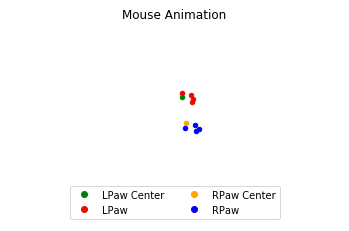

In [43]:
# create animation   #NOT WORKING with Jupyter
Animate(df_all_best)

<br/><br/>
<br/><br/>
<br/><br/>
ID 2D CAMERA OUTLIERS
<br/><br/>
<br/><br/>
<br/><br/>

IMPORT MODULES

In [21]:
from matplotlib.patches import Rectangle
from scipy import stats

FUNCTIONS

In [22]:
# PREPROCESS DLC AND KEEP LIKELIHOOD VALUES
# input: DLC csv as df
# output: processed DLC file with extra info removed, list of likelihood columns

def pp(df):

    for y in range (df.shape[1]):        
        df.rename(columns={df.columns[y]:df.iloc[0,y]+'_'+df.iloc[1,y]}, inplace=True)
        
    df_proc = df.iloc[2:,1:]
    df_proc = df_proc.astype(float).reset_index(drop=1)

    licol = [col for col in df_proc.columns if 'likelihood' in col]
        
    return df_proc, licol

In [23]:
# PLOT 2D PLOT OF BODYPART IN CAMERA VIEW WITH OUTLIERS ID'd
# input: preprocessed DLC df, camera ID as string ('fl','fr','bot'), list of low likelihood values to ID as outlier
# output: seperate PNG plot for each bodypart in camera view


def plot2d(df,cam,l):
    
    # create/switch to folder for each camera
    # CHANGE TO LOCAL PATH/TRIAL FOLDER
    path = 'D:/data/Behavior data/dlc_data_201020/Plotting files/trial 11/' + cam
    if not os.path.isdir(path):
        os.mkdir(path)
    os.chdir(path)

    parts = [col[:-2] for col in df.columns[::3]]
    for i,p in enumerate(parts):
        fig = plt.figure()
        fig.clf()
        ax = fig.add_subplot(111)
        rect1 = Rectangle((0, 0), 640, 480, fill=0, color='k', ls='--')
        x = p+'_x'
        y = p+'_y'

        # ID outliers using IQR
        dist = np.sqrt(df[x]**2+df[y]**2)
        Q1 = dist.quantile(0.25)
        Q3 = dist.quantile(0.75)
        IQR = Q3 - Q1
        mask_IQR = (dist < (Q1 - 1.5 * IQR)) | (dist > (Q3 + 1.5 * IQR))
        idx_IQR = dist[mask_IQR].index.values


        # ID outliers using Z score
        z = np.abs(stats.zscore(dist))
        mask_z = z>3
        idx_z = dist[mask_z].index.values

        # print(p,'outlier likelihood IQR:')
        # print(*df.iloc[idx_IQR,3*i-1].values, sep='\n')
        # print(p,'outlier likelihood z-score:')
        # print(*df.iloc[idx_z,3*i-1].values, sep='\n')
        # print()

        # plot points
        ax.scatter(df[x],df[y], label = 'points')
        # plot outliers based on likelihood values in yellow
        ax.scatter(df[x][l[i]], df[y][l[i]], color='yellow', label = 'likelihood outliers')
        # circle outliers based on Z score in red
        ax.scatter(df[x][idx_z], df[y][idx_z], facecolors='none', edgecolors='r', s=50, label = 'z score outliers')

        if df[x].min() > 0 and df[x].max() < 640 and df[y].min() > 0 and df[y].max() < 480:
            plt.xlim([0,640])
            plt.ylim([0,480])
        else:
            ax.add_artist(rect1)
            plt.xlim([min(df[x].min(), 0) - 10, max(df[x].max(), 640) + 10])
            plt.ylim([min(df[y].min(), 0) - 10, max(df[y].max(), 480) + 10])

        plt.title(p)
        plt.legend()
        plt.savefig(p)
        plt.close()

    return

PROCESS DLC FILES AND PLOT WITH OUTLIERS ID'd

In [24]:
# process DLC files
# local path to DLC folder
front_left = pd.read_csv(pathsDict['DLCPath'] + '/front_left.csv')
front_right = pd.read_csv(pathsDict['DLCPath'] + '/front_right.csv') 
bot = pd.read_csv(pathsDict['DLCPath'] + '/bot.csv')

# preprocess
fl, fl_li = pp(front_left)
fr, fr_li = pp(front_right)
bot, bot_li = pp(bot)

# list of models/cameras/likelihood columns to iterate over to produce plots
mod = [fl,fr,bot]
cam = ['fl','fr','bot']
lik = [fl_li,fr_li,bot_li]

# threshold level for likelihood values
perc = .01

for m,c,li in zip(mod,cam,lik):

    # find low likelihood values to ID as outlier
    low = []
    for col in m[li].columns:
        low.append(m[m[col]<perc].index.values.tolist())

    # create plot
    plot2d(m,c,low)
    
    # print message when done
    print('done with',c)

done with fl
done with fr
done with bot


<br/><br/>
<br/><br/>
<br/><br/>
ID WHEN MOUSE IS STOPPED
<br/><br/>
defined as when absolute value of Z velocity is less than user-defined threshold for user-defined duration
<br/><br/>
<br/><br/>
<br/><br/>

In [25]:
# GET FRAMES WHERE PAWS ARE STOPPED
# input: list of dfs for each paw
# output: ids - every frame where a paw is stopped
#         ids_range - range of frames where any paw is stopped
#         ids_range_common - range of frames where all paws are stopped

def get_ids(dfs):

    all_ids = []

    for df in dfs:
        dfZ = df[[col for col in df.columns if col[-5:] == 'paw_Z']]
        npZ  = dfZ.to_numpy().ravel()
        diff = np.gradient(npZ)

        # SET VELOCITY THRESHOLD
        tol = .2

        stop_id = np.array(np.where(abs(diff)<tol)).ravel()
        ids = []

        # SET DURATION
        dur = 70

        passing = 0
        for i,val in enumerate(stop_id[:-dur]):
            if stop_id[i+dur-1] == val+dur-1:
                ids.append(i)
                passing = 0
            elif i-1 in ids and not passing:
                ids.extend(np.arange(i,i+dur-1))
                passing = dur-1
            elif passing:
                passing -= 1
            else:
                pass

        all_ids.append(stop_id[ids])

    # any paw stopped
    ids = list(sorted(set([i for sl in all_ids for i in sl])))
    gaps = [[s, e] for s, e in zip(ids, ids[1:]) if s+1 < e]
    edges = iter(ids[:1] + sum(gaps, []) + ids[-1:])
    ids_range = list(zip(edges, edges))

    # all paws stopped
    common = set(all_ids[0])
    for s in all_ids[1:]:
        common.intersection_update(s)

    ids_common = list(sorted(common))
    gaps_common = [[s, e] for s, e in zip(ids_common, ids_common[1:]) if s+1 < e]
    edges_common = iter(ids_common[:1] + sum(gaps_common, []) + ids_common[-1:])
    ids_range_common = list(zip(edges_common, edges_common))

    return ids, ids_range, ids_range_common

PLOT Z OVER TIME AND ID WHEN STOPPED

In [27]:
# plot X/Y/Z over time (see when walking)

chdr(11, pathsDict)
%matplotlib

# get ids when stopped for left/right paw
ids, ids_r, ids_r_com = get_ids([lpaw, rpawbest])

# plot Z for left/right paw
df_z = df_all[[col for col in df_all.columns if col[-3] == 'w' and col[-1] == 'Z']]
df_z.plot()
plt.title('Paw Elev')
# plt.ylim(-20,50)

# overlay ranges where paw is stopped
for i,val in enumerate(ids_r_com):
    plt.axvspan(val[0], val[1], color='r', alpha=0.2, label='_'*i + 'stop')

# function to offset xticks
def offset_xticks(xlabels):
    return ('\n%.2f' % label if i % 2 else '%.2f' % label for i, label in enumerate(xlabels))

# convert frames to seconds (divide by 70 fps)
xl = [i/70 for l in ids_r_com for i in l]
# set xticks and offset for start/stop ranges
plt.xticks([i for l in ids_r_com for i in l], offset_xticks(xl))
plt.xlabel('Time')
plt.ylabel('Elev (Z coord)')
plt.legend()

plt.savefig('mouse_stop')

D:\data\Behavior data\dlc_data_201020\Plotting files\trial 11
Using matplotlib backend: Qt5Agg


<br/><br/>
<br/><br/>
<br/><br/>
GRAPHS FOR PAPER
<br/><br/>
digit distances over time
<br/><br/>
<br/><br/>
<br/><br/>

IMPORT MODULES

In [39]:
from matplotlib.pyplot import cm    # used for colormap

FUNCTIONS

In [40]:
# DISTANCE FROM PAW TO DIGITS
# input: model df
# output: df_dist - df of digit distances
#         colL/R - list of digit distance column names for left/right paw

def digit_dist(df):

    # seperate into paw base and digits
    baseL = [col for col in df.columns if col[0] == 'L' and col[5] != 'D']
    baseR = [col for col in df.columns if col[0] == 'R' and col[5] != 'D']
    digitL = [col for col in df.columns if col[0] == 'L' and col[5] == 'D']
    digitR = [col for col in df.columns if col[0] == 'R' and col[5] == 'D']

    # create new df and empty col lists
    df_dist = pd.DataFrame()
    colL = []
    colR = []

    # iterate over L/R paws
    for b,d,c in [[baseL, digitL, colL], [baseR, digitR, colR]]:
        # iterate over each digit in paw
        for i in range(len(digitL)//3):
            base = df[b]
            digit = df[d].iloc[:,3*i:3*i+3]
            c.append(digit.columns[0][:-2]+'_dist')
            base.columns=digit.columns = ['x','y','z']
            diff = base-digit
            df_dist[c[i]] = np.linalg.norm(diff, axis=1)
    
        df_dist[b[0][:-2]+'_sum_dist'] = df_dist[c].sum(axis=1)

    return df_dist, colL, colR

In [44]:
# GRAPH OF DISTANCE FROM PAW TO DIGITS
# input: df of digit distances of single paw
# output: 5 subplots -
#         1. cumulative digit distance of D1-D4 over time
#         2-5. seperate plots of digit distance for D1-D4 over time

def dist_graph(df):

    # reorder: cum dist, D1-4 dist
    if df.columns[0][5] == 'D':
        cols = list(df.columns)
        cols = [cols[-1]]+cols[:-1]
        df = df[cols]
    else:
        cols = df.columns

    # set color scheme for left vs right paw
    if df.columns[0][0] == 'L':
        paw = 'r'
        cmap = cm.Reds(np.linspace(.25,.5,4))
    elif df.columns[0][0] == 'R':
        paw = 'b'
        cmap = cm.Blues(np.linspace(.5,.75,4))
    else:
        print('error!')
        return

    # plot all 5 subplots
    fig, ax = plt.subplots(5, sharex=True)
    for i in range(len(ax)):
        if i == 0:
            ax[i].plot(df.iloc[:,i], c=paw)
        else:
            ax[i].plot(df.iloc[:,i], c=cmap[i-1])

        ax[i].title.set_text(cols[i][:-5])
       
        if i > 0:
            ax[i].set_ylim([0,25])

    fig.tight_layout()

    return

CALCULATE DIGIT DISTANCES AND PLOT

In [64]:
%matplotlib

# digit distances
df_digit_dist, colL, colR = digit_dist(df_all_best)

# overlay left and right paw cumulative distances over time
plt.plot(df_digit_dist['Lpaw_sum_dist'], c='r', label='Left Paw')
plt.plot(df_digit_dist['Rpaw_sum_dist'], c='b', label = 'Right Paw')

# optional, zoom in on snippet where mouse is walking to see alternating left and right paw
# plt.ylim([0,30])
# plt.xlim([3500,4000])

# optional, include ranges where paw is stopped
ids, ids_r, ids_r_com = get_ids([lpaw, rpawbest])
for i,val in enumerate(ids_r_com):
    plt.axvspan(val[0], val[1], color='r', alpha=0.2, label='_'*i + 'stop')
plt.legend()

Using matplotlib backend: MacOSX


In [65]:
# optional, overlay all digits for left/right paw
df_digit_dist[colL].plot()

# optional, include ranges where paw is stopped
ids, ids_r, ids_r_com = get_ids([lpaw, rpawbest])
for i,val in enumerate(ids_r_com):
    plt.axvspan(val[0], val[1], color='r', alpha=0.2, label='_'*i + 'stop')
plt.legend()

In [73]:
# graphs of left and right digit distances

%matplotlib
Ldist = df_digit_dist[[col for col in df_digit_dist if col[0]=='L']]
Rdist = df_digit_dist[[col for col in df_digit_dist if col[0]=='R']]
dist_graph(Ldist)
dist_graph(Rdist)

Using matplotlib backend: MacOSX


<br/><br/>
<br/><br/>
<br/><br/>
CURRENT WORK...
<br/><br/>
<br/><br/>
<br/><br/>

ID DIGIT DISTANCE OUTLIERS

In [163]:
Ldist.describe()

,Lpaw_D1_dist,Lpaw_D2_dist,Lpaw_D3_dist,Lpaw_D4_dist,Lpaw_sum_dist
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.254400,5.016632,5.304682,3.129053,17.704767
std,0.794334,0.867811,0.898782,0.517251,2.824821
min,1.150834,0.255708,0.661368,0.780541,5.365356
25%,4.006216,4.818911,5.064665,2.895824,16.972285
50%,4.383668,5.179327,5.454447,3.178747,18.224751
75%,4.713313,5.464264,5.835100,3.420673,19.192311
max,23.817088,22.362831,21.128344,20.957888,88.266151


In [23]:
from scipy import stats
Ldist[(np.abs(stats.zscore(Ldist)) > 3).all(axis=1)]

,Lpaw_D1_dist,Lpaw_D2_dist,Lpaw_D3_dist,Lpaw_D4_dist,Lpaw_sum_dist
102,23.817088,22.362831,21.128344,20.957888,88.266151
358,6.869291,10.130953,9.013518,9.836375,35.850138
1257,1.726407,1.409851,2.382571,1.323962,6.842791
4052,1.486387,1.406840,1.545653,1.405969,5.844849


In [21]:
test = np.abs(stats.zscore(Ldist.iloc[:,0])) > 3
[i for i,x in enumerate(test) if x]

[102,
 193,
 358,
 1257,
 1469,
 1470,
 1513,
 1514,
 1554,
 1556,
 1557,
 1596,
 1597,
 1644,
 1725,
 2509,
 2510,
 2511,
 2513,
 2557,
 2558,
 2559,
 2603,
 2646,
 2647,
 2780,
 2820,
 2921,
 2922,
 2924,
 3641,
 3854,
 3855,
 3998,
 4051,
 4052,
 4135,
 4136,
 4272,
 4273,
 4274,
 4294,
 4319,
 4497,
 5149,
 5257,
 5296,
 5355,
 5356,
 5357,
 5360,
 5460,
 5516,
 5531,
 5571]